In [1]:
import sys
import warnings
sys.path.append("../Pythonscripts")
sys.path.append(r"C:\Users\atedi\OneDrive\Documents\SageBionetworks\synapse\Scripts")
import pandas as pd
import numpy as np
import synapseclient as sc
from pdkit_features import pdkit_normalize
warnings.simplefilter("ignore")

In [2]:
## login to synapse
syn = sc.login()

Welcome, aryton tediarjo!



INFO:synapseclient_default:Welcome, aryton tediarjo!



In [3]:
## helper function
def fill(params):
    try:
        return float(params)
    except:
        return np.NaN
    
def data_to_float(train):
    for feat in train.columns:
        if feat != "healthCode" and feat != "PD":
            train[feat] = train[feat].astype(float) 
    return train

# Retrieve Data from Synapse

In [4]:
## get sfm data
entity = syn.get("syn20817213")
sfm_data = pd.read_csv(entity["path"], index_col = 0)
for feat in [feat for feat in sfm_data.columns if "sfm" in feat]:
    sfm_data[feat] = sfm_data[feat].apply(fill)
    

## get pdkit data
entity = syn.get("syn20817011")
pdkit_data = pd.read_csv(entity["path"], index_col = 0)

## filter data
filtered_entity = syn.get("syn8381056")
filtered_healthcode_data = pd.read_csv(filtered_entity["path"], sep = "\t")
filtered_healthcode_list = list(filtered_healthcode_data["healthCode"])

# Combine Outbound and Return Data

In [6]:
## combine outbound and return into the same feature to reduce feature space

walking_columns = [feat for feat in pdkit_data.columns if ("features" in feat) 
                   and ("outbound" in feat or "return" in feat)]

walking_data = pdkit_data[[feat for feat in pdkit_data.columns if (feat in walking_columns) 
                     or ("healthCode" in feat)]]

temp = walking_data.copy()

temp = temp.rename(columns = {"accel_return_features_x" : "accel_walking_features_x", 
                              "userAccel_return_features_x" : "userAccel_walking_features_x",
                              "accel_return_features_y" : "accel_walking_features_y", 
                              "userAccel_return_features_y" : "userAccel_walking_features_y",
                              "accel_return_features_z" : "accel_walking_features_z", 
                              "userAccel_return_features_z" : "userAccel_walking_features_z",
                              "accel_return_features_AA" : "accel_walking_features_AA", 
                              "userAccel_return_features_AA" : "userAccel_walking_features_AA"
                             })
walking_data = walking_data.rename(columns = {"accel_outbound_features_x" : "accel_walking_features_x", 
                              "userAccel_outbound_features_x" : "userAccel_walking_features_x",
                              "accel_outbound_features_y" : "accel_walking_features_y", 
                              "userAccel_outbound_features_y" : "userAccel_walking_features_y",
                              "accel_outbound_features_z" : "accel_walking_features_z", 
                              "userAccel_outbound_features_z" : "userAccel_walking_features_z",
                              "accel_outbound_features_AA" : "accel_walking_features_AA", 
                              "userAccel_outbound_features_AA" : "userAccel_walking_features_AA"
                             })

# Concatenate return and outbound data
walking_data = pd.concat([walking_data, temp], ignore_index = True)
walking_data = walking_data[[feat for feat in walking_data.columns if ("walking" in feat) or ("healthCode" in feat)]]
walking_data = pdkit_normalize(walking_data)

# Grouped Data per HealthCode

In [7]:
## group sfm data
mean_sfm_data = sfm_data.groupby("healthCode").mean()[[feat for feat in sfm_data.columns if "sfm" in feat]].reset_index()
mean_sfm_data.columns = ["healthCode"] + ["mean_{}".format(_) for _ in mean_sfm_data.columns if "sfm" in _]
min_sfm_data = sfm_data.groupby("healthCode").min()[[feat for feat in sfm_data.columns if "sfm" in feat]].reset_index()
min_sfm_data.columns = ["healthCode"] + ["min_{}".format(_) for _ in min_sfm_data.columns if "sfm" in _]
max_sfm_data = sfm_data.groupby("healthCode").max()[[feat for feat in sfm_data.columns if "sfm" in feat]].reset_index()
max_sfm_data.columns = ["healthCode"] + ["max_{}".format(_) for _ in max_sfm_data.columns if "sfm" in _]


mean_walking_data = walking_data.groupby("healthCode").mean()[["no_of_steps accel_walking_features_AA", 
                                                               "speed_of_gait accel_walking_features_AA", 
                                                               "gait_symmetry userAccel_walking_features_x",
                                                              "gait_step_regularity accel_walking_features_z"]].reset_index()

mean_walking_data.columns = ["healthCode"] + ["mean_{}".format(_) for _ in mean_walking_data.columns if "features" in _]

max_walking_data = walking_data.groupby("healthCode").max()[["median_freeze_index userAccel_walking_features_x",
                                                            "median_freeze_index accel_walking_features_x",
                                                            "median_freeze_index accel_walking_features_y",
                                                            "median_freeze_index accel_walking_features_z",
                                                            "median_freeze_index accel_walking_features_AA",
                                                            "count_freeze_index userAccel_walking_features_x",
                                                            "count_freeze_index userAccel_walking_features_y",
                                                            "count_freeze_index userAccel_walking_features_z",
                                                            "count_freeze_index userAccel_walking_features_AA",
                                                            "gait_symmetry userAccel_walking_features_x",
                                                            "gait_symmetry userAccel_walking_features_z"]].reset_index()
max_walking_data.columns = ["healthCode"] + ["max_{}".format(_) for _ in max_walking_data.columns if "features" in _]

In [24]:
# walking_data = pd.merge(mean_walking_data, max_walking_data, how = "inner", on = "healthCode")
walking_data = pd.merge(max_walking_data, filtered_healthcode_data[["healthCode", "PD"]], how = "inner", on = "healthCode")

balance_data = pd.merge(mean_sfm_data, min_sfm_data, how = "inner", on = "healthCode")
balance_data = pd.merge(balance_data, max_sfm_data, how = "inner", on = "healthCode")
balance_data = pd.merge(balance_data, filtered_healthcode_data[["healthCode", "PD"]], how = "inner", on = "healthCode")

In [25]:
walking_data["PD"] = walking_data["PD"].map({True:1, False:0})
balance_data["PD"] = balance_data["PD"].map({True:1, False:0})

# Save to CSV

In [26]:
walking_data_training = data_to_float(walking_data)
balance_data_training = data_to_float(balance_data)

In [27]:
def save_data(data, name):
    path = "../Data/{}.csv"
    data.to_csv(path.format(name))

# walking_data_training.to_csv("../Data/walking_data_training.csv")
# balance_data_training.to_csv("../Data/balance_data_training.csv")

save_data(walking_data_training, "walking_data_training")

# EDA

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

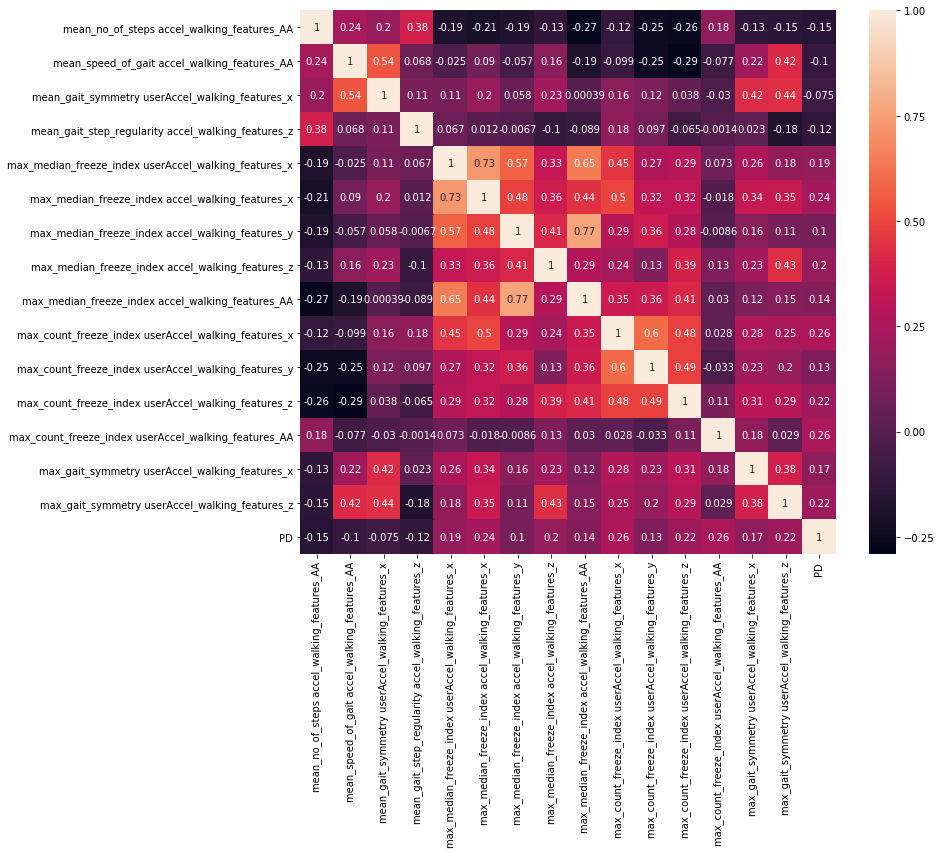

In [13]:
## check multicollinearity in features
plt.figure(figsize=(12,10))
ax = sns.heatmap(walking_data.corr(), annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

## Removing Multicollinearity

In [14]:
data = walking_data.copy()

## Remove Highly Correlated Features ##
data= data.drop(["max_median_freeze_index userAccel_walking_features_x", 
                 "max_median_freeze_index accel_walking_features_AA"
                ], axis = 1)

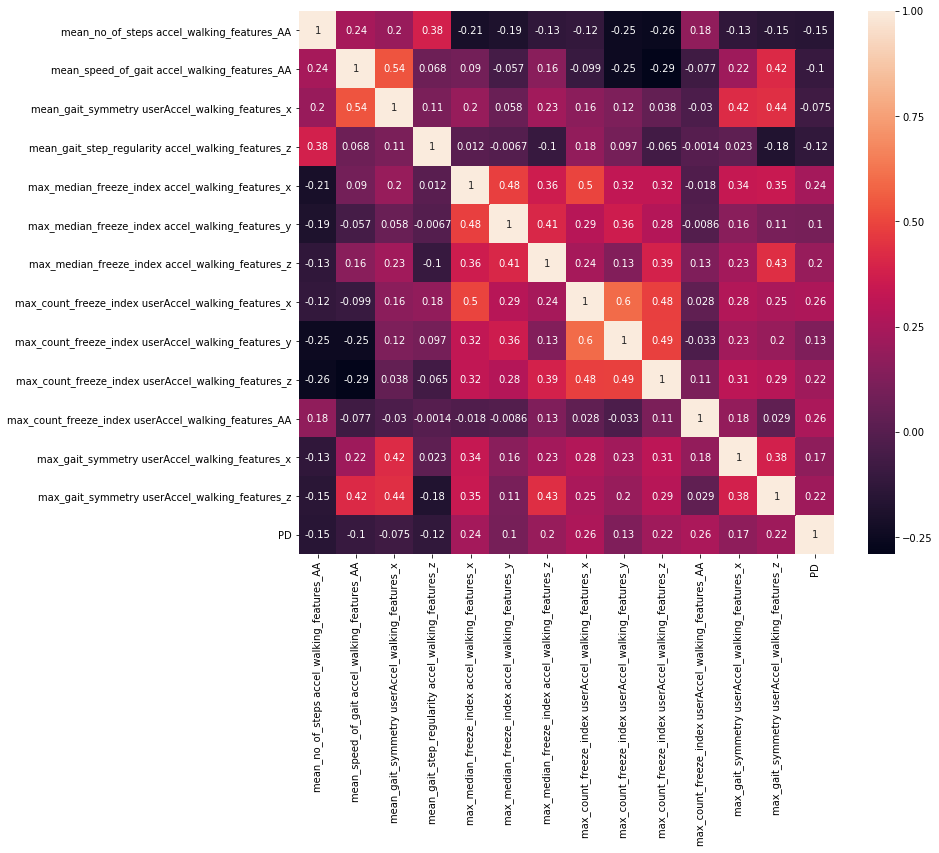

In [15]:
## check multicollinearity in features
plt.figure(figsize=(12,10))
ax = sns.heatmap(data.corr(), annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [16]:
save_data(data, "walking_data_training")

# Feature Engineering on Walking Data

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, data["PD"], test_size=0.25, random_state = 100)

In [18]:
## Approach 1: maximize separation between PD and non-PDs

## fill PD with max or min that depends on features
## drop na to all test set

In [23]:
X_train.groupby("PD").agg(["mean"]).T

,PD,0,1
mean_no_of_steps accel_walking_features_AA,mean,16.225437,14.739229
mean_speed_of_gait accel_walking_features_AA,mean,0.250280,0.232475
mean_gait_symmetry userAccel_walking_features_x,mean,0.041248,0.036739
mean_gait_step_regularity accel_walking_features_z,mean,0.743889,0.698831
max_median_freeze_index accel_walking_features_x,mean,6.299891,8.271180
max_median_freeze_index accel_walking_features_y,mean,5.528340,5.604397
max_median_freeze_index accel_walking_features_z,mean,4.848422,6.884550
max_count_freeze_index userAccel_walking_features_x,mean,33.942857,38.391892
max_count_freeze_index userAccel_walking_features_y,mean,34.214286,36.945946
max_count_freeze_index userAccel_walking_features_z,mean,30.300000,35.837838
